In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
# Load and preprocess data
df = pd.read_csv('temperature_data.csv')
print(df.head())

temperature_data = df['Temperature'].values
print(type(temperature_data))
print(len(temperature_data))
print(temperature_data[:10])

   Day  Temperature
0    1     0.133553
1    2     0.061635
2    3     0.175963
3    4     0.302001
4    5     0.082970
<class 'numpy.ndarray'>
365
[0.13355308 0.06163542 0.17596309 0.30200063 0.08296965 0.09425032
 0.34319699 0.24803459 0.09712456 0.24096815]


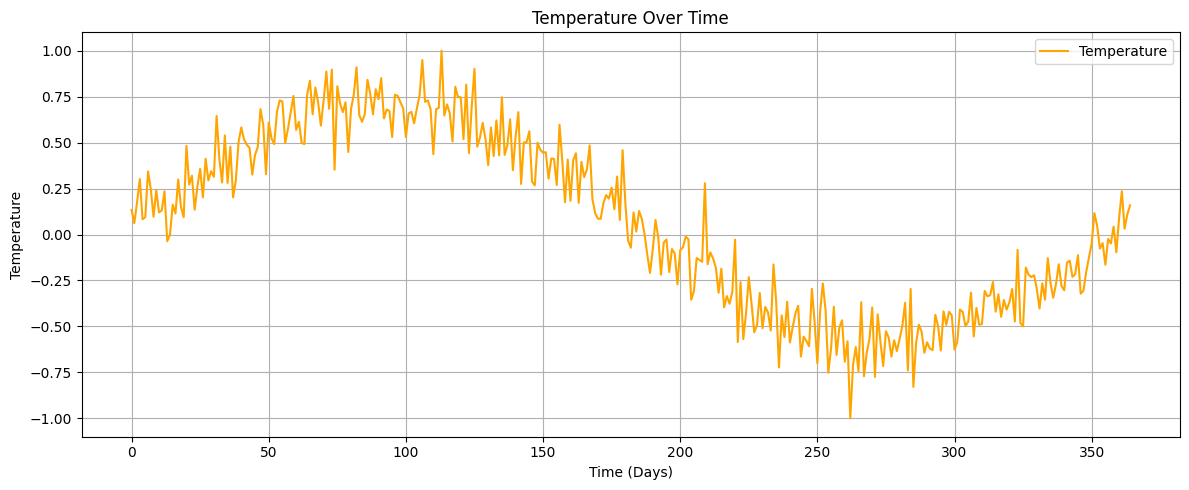

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(temperature_data, label='Temperature', color='orange')
plt.title('Temperature Over Time')
plt.xlabel('Time (Days)')
plt.ylabel('Temperature')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
print("Minimum temperature:", temperature_data.min())
print("Maximum temperature:", temperature_data.max())

Minimum temperature: -1.0
Maximum temperature: 1.0


In [5]:
# temperature_data = np.array([16.2, 14.8, 17.1, 18.3])

# We reshape the 1D array into 2D (needed for scalers):
# temperature_data.reshape(-1, 1)
# [[16.2],[14.8],[17.1],[18.3]]

# scaler.fit_transform(...)
# [[0.4],[0.0],[0.6571],[1.0]]

# flatten()
# This converts the shape from (4, 1) to (4,).

# Final output:
# temperature_data_normalized = [0.4, 0.0, 0.6571, 1.0]
scaler = MinMaxScaler(feature_range=(-1, 1))
temperature_data_normalized = scaler.fit_transform(temperature_data.reshape(-1, 1)).flatten()

In [6]:
# since temperature data has 365 entries, this will give:
# days = array([0, 1, 2, ..., 364])
# Create time features (day of year) to capture seasonality
print(len(temperature_data))
days = np.arange(len(temperature_data))
print(len(days))
# print(days)

365
365


In [7]:
# Scenario	What to Use
# exactly 365 values (1 year)	✅ Use 365
# multi-year data	✅ Use 365.25
# building a general model	✅ Use 365.25 (safe choice)
#  the period of the wave is 2π radians, which corresponds to one full cycle.

In [8]:
# This gives values between -1 and 1, creating a smooth, repeating pattern over the year.
day_of_year = np.sin(2 * np.pi * days / 365)  # Sinusoidal representation of day of year

# Combine temperature with time features
combined_data = np.column_stack((temperature_data_normalized, day_of_year))
# print(combined_data)

 If you only have 365 values for a single year, you don’t necessarily need to use a sinusoidal curve to represent the time of year. However, it depends on your use case, specifically how you want to represent the seasonal information in your model.

Why Use a Sinusoidal Curve?
The sinusoidal curve is often used for encoding seasonality or cyclical patterns over time because:

Smooth Transition: It allows for a smooth transition between seasons, so the end of the year can easily connect to the start of the next year. Without the sinusoidal encoding, you could lose this smoothness.

Cyclic Nature: Days of the year repeat in a cycle (e.g., Day 1 of the year is similar to Day 365), so the sinusoidal function makes sure that Day 365 is closely aligned with Day 1 when encoding temporal features. This ensures continuity when predicting patterns across years.

Model Interpretation: If your model learns from seasonal trends, the sinusoidal representation of days gives it an easy-to-understand feature for predicting yearly fluctuations, like temperature cycles.



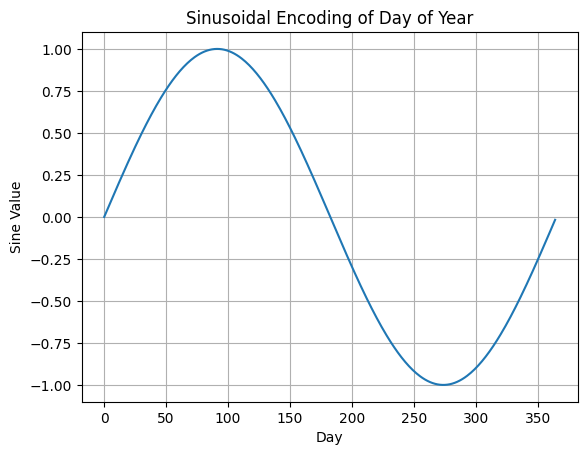

In [9]:
plt.plot(days, day_of_year)
plt.title("Sinusoidal Encoding of Day of Year")
plt.xlabel("Day")
plt.ylabel("Sine Value")
plt.grid(True)
plt.show()


In [10]:
np.random.seed(42)
seq_length = 7  # 7 to capture more temporal patterns
batch_size = 64  # Increased batch size for better stability

In [11]:
# TimeSeriesDataset is a custom subclass of the Dataset class from PyTorch's torch.utils.data module. 
# This custom class is used to process time series data into manageable sequences that can be fed into the model during training.
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, i):
        x = self.data[i:i+self.seq_length]
        y = self.data[i+self.seq_length, 0]  # Only predict temperature, not time features
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

dataset = TimeSeriesDataset(combined_data, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False) 


In [12]:
# LSTM Layer (self.lstm1):
# The LSTM layer processes sequential data, remembering long-term dependencies. It has:
# input_dim: The number of features per time step in the input sequence.
# hidden_dim: The number of LSTM units (this is the size of the hidden state at each time step).
# num_layers=2: Two stacked LSTM layers (this helps capture more complex patterns).
# batch_first=True: Ensures the input and output tensors have the shape [batch_size, sequence_length, input_dim].
# dropout=0.2: Dropout between LSTM layers to prevent overfitting.\



# Multi-Head Attention (self.attention):
# The multi-head attention mechanism allows the model to focus on different parts of the sequence.
# It takes the output from the LSTM and computes attention scores between different parts of the sequence.
# hidden_dim: The size of the input and output of the attention layer (it must match the LSTM hidden state size).
# num_heads=4: The number of attention heads. More heads allow the model to focus on multiple aspects of the sequence simultaneously.

# Layer Normalization (self.norm):
# Layer normalization is applied to the output of the LSTM and attention layers. 
# It normalizes across the feature dimension, improving training stability and reducing internal covariate shift.


# Fully Connected Layers (self.fc1, self.fc2):
# fc1: A fully connected layer that reduces the size of the output from hidden_dim to hidden_dim // 2.
# fc2: The final fully connected layer that maps the output to the desired output_dim 
# (the prediction, which could be a single temperature value).


# x: The input tensor to the model, typically a sequence of data (like temperature and time-related features).
# batch_size: The number of sequences in the current batch.

# h_0 and c_0: The initial hidden state and cell state for the LSTM. 
# They are initialized to zeros here, with a size of (num_layers, batch_size, hidden_dim).
# (2, batch_size, self.hidden_dim): This specifies the shape of the tensor:
# 2: The number 2 indicates that the LSTM has 2 layers 
# (since LSTM is a stacked network of multiple layers). 
# This is the number of hidden states in the LSTM's first dimension. 
# Each LSTM layer will have its own hidden state, and this 2 is used to keep track of both the hidden states in a multi-layer LSTM.
# batch_size: This represents the number of sequences in each batch. 
# The model processes multiple sequences in parallel (hence the batch size), so this dimension tracks the hidden state for each sequence in the batch.
# self.hidden_dim: This represents the number of units (or neurons) in the hidden state of the LSTM. 
# The hidden state size must match the size of the LSTM's internal state. 
# This is the number of features each time step's hidden state will have.


# The LSTM layer processes the input sequence x and outputs lstm_out, which contains the hidden states for each time step in the sequence.
# Self-attention: The attn_out is the result of applying the attention mechanism to lstm_out. The attention mechanism compares different parts of the sequence and adjusts based on their relevance.
# Residual connection: The attention output is added to the LSTM output (lstm_out + attn_out) to allow the network to retain the LSTM information. Layer normalization is applied to the result.

# out = lstm_out[:, -1, :]: Selects the last hidden state from the LSTM output (corresponding to the last time step of the sequence) for use in prediction. 
# This is the information we use to predict the next time step.


In [14]:
# Generator inherits from nn.Module, meaning it is a subclass of PyTorch's base class for neural networks.
# input_dim is the number of features in the input sequence (the number of features for each time step: temperature + day of the year).
# hidden_dim is the size of the hidden state in the LSTM, which also determines the number of units in the attention mechanism and other layers.
# output_dim is the size of the output. For time series forecasting, this could be 1 (the next predicted temperature).
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        
        # architecture
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.2)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(2, batch_size, self.hidden_dim).to(x.device)
        c_0 = torch.zeros(2, batch_size, self.hidden_dim).to(x.device)
        
        # LSTM layer
        lstm_out, _ = self.lstm1(x, (h_0, c_0))
        
        # Self-attention mechanism
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        lstm_out = self.norm(lstm_out + attn_out)  # Residual connection
        
        # Use the last output for prediction
        out = lstm_out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.tanh(out)
        
        return out.unsqueeze(1)  # Shape: [batch_size, 1, 1]

In [15]:
# Use the LSTM outputs (lstm_out) as:
# query: What each timestep is looking for
# key: How other timesteps describe themselves
# value: What information each timestep contains

# This allows the model to compute relationships between each timestep in the sequence, letting it focus on the most relevant parts — like attention over time.

# 📌 When would you use different inputs?
# If you're doing cross-attention (like in transformers where the decoder attends to encoder outputs), then:
# attn_out = attention(query=decoder_output, key=encoder_output, value=encoder_output)

In [16]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_length):
        super(Discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        
        # Improved discriminator architecture
        # A 2-layer Bidirectional LSTM (so it learns from both past and future context).
        # bidirectional=True → Output dimension doubles (hidden_dim * 2).
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)
        # Adds self-attention to help the model focus on important time steps.
        # hidden_dim * 2 is because of the bidirectional LSTM.
        self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=4, batch_first=True)
        # Normalize for stability
        self.norm = nn.LayerNorm(hidden_dim * 2)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)
        # Output a single real/fake score
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        # Reshape real data to be compatible with generated data if needed
        # If your data has temperature + time (like [[temp, sin(day)], [temp, sin(day)], ...]), 
        # this selects only the temperature for discrimination.
        if x.size(2) > 1:  # If input has time features
        #[batch_size, sequence_length, num_features]
            # x[:, :, 0]
            # : — selects all batches
            # : — selects all timesteps in each sequence
            # 0 — selects the first feature only (which is temperature)
            x = x[:, :, 0].unsqueeze(2)  # Only use temperature values
            
        batch_size = x.size(0)
        h_0 = torch.zeros(4, batch_size, self.hidden_dim).to(x.device)  # 4 because bidirectional
        c_0 = torch.zeros(4, batch_size, self.hidden_dim).to(x.device)
        
        lstm_out, _ = self.lstm(x, (h_0, c_0))
        
        # Self-attention mechanism
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        lstm_out = self.norm(lstm_out + attn_out)  # Residual connection
        
        out = lstm_out[:, -1, :]  # Use the last step output
        out = self.fc1(out)
        out = self.leaky_relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out


In [17]:
# Seasonal pattern loss to encourage capturing seasonal temperature patterns
# A custom loss function that penalizes the generator if the generated temperature data does not follow a seasonal pattern
# torch.arange(generated_data.size(0)): Creates an array [0, 1, 2, ..., N-1] 
# where N is the batch size (i.e., number of generated samples).
def seasonal_pattern_loss(generated_data, day_features, period=365):
    # Compute correlation between generated data and seasonal pattern
    # Result: a sinusoidal wave simulating the natural seasonal pattern of temperature.
    seasonal_pattern = torch.tensor(np.sin(2 * np.pi * torch.arange(generated_data.size(0)) / period), 
                                    dtype=torch.float32).to(generated_data.device)
    correlation = 1.0 - torch.abs(torch.corrcoef(torch.stack([generated_data.squeeze(), seasonal_pattern]))[0, 1])
    # Lower values of this loss indicate better alignment with seasonal pattern.
    # It's used to guide the generator to learn realistic, seasonal time series.
    return correlation


In [18]:
# Enhanced smoothness loss with adaptive weight based on expected natural variations
# This enhanced_smoothness_loss function is designed to penalize sudden or unnatural changes in the generated temperature data, 
# making the generated time series smoother and more realistic.

# generated_data: shape [batch_size, sequence_length], typically the temperature values generated by the model.
# alpha: a weighting factor that controls the influence of second-order (acceleration) smoothness. Default is 1.0.
def enhanced_smoothness_loss(generated_data, alpha=1.0):
    # This computes the day-to-day change between each pair of time steps.
    # First-order differences (day-to-day changes)
    first_diff = torch.abs(generated_data[:, 1:] - generated_data[:, :-1])
    
    # Second-order differences (acceleration)
    # Second-order differences capture acceleration or sudden jumps in change.
    # For [1, 2] from above: second_diff = |2 - 1| = 1.
    # This helps penalize inconsistent change patterns like "up-down-up" spikes.
    # Need at least 3 time steps to compute the second-order difference, like this:
    if generated_data.size(1) > 2:
        second_diff = torch.abs(first_diff[:, 1:] - first_diff[:, :-1])
        return torch.mean(first_diff) + alpha * torch.mean(second_diff)
    
    return torch.mean(first_diff)


In [19]:
# Parameters
input_dim = 2  # Temperature + day of year feature
output_dim = 1
hidden_dim = 128  # Increased hidden dimension
num_epochs = 1000  # More epochs for better convergence

# Initialize model
generator = Generator(input_dim, hidden_dim, output_dim)
discriminator = Discriminator(output_dim, hidden_dim, seq_length)

# Use better optimizers with learning rate scheduling
OptimizerG = optim.AdamW(generator.parameters(), lr=0.0005, weight_decay=1e-5)
OptimizerD = optim.AdamW(discriminator.parameters(), lr=0.0001, weight_decay=1e-5)

# Learning rate schedulers
scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(OptimizerG, 'min', patience=50, factor=0.5)
scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(OptimizerD, 'min', patience=50, factor=0.5)

adversarial_criterion = nn.BCEWithLogitsLoss()
mse_criterion = nn.MSELoss()

# Training history for plotting
g_losses = []
d_losses = []
smooth_losses = []

Epoch [1/1000] Loss D: 1.4005, Loss G: 5.5210, Smoothness Loss: 0.3073


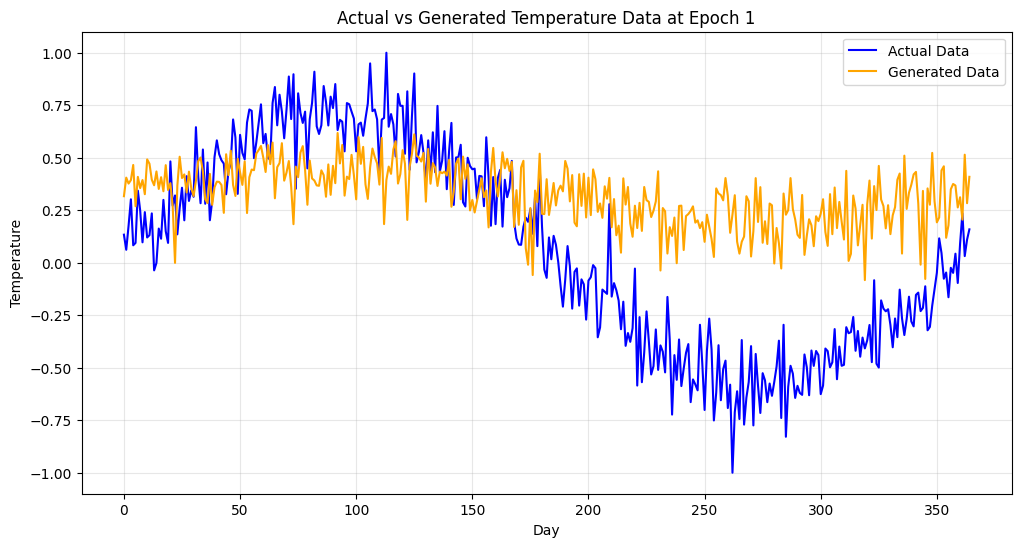

Epoch [11/1000] Loss D: 1.3863, Loss G: 0.9609, Smoothness Loss: 0.1901
Epoch [21/1000] Loss D: 1.3848, Loss G: 0.9241, Smoothness Loss: 0.1875
Epoch [31/1000] Loss D: 1.3826, Loss G: 0.9593, Smoothness Loss: 0.1885
Epoch [41/1000] Loss D: 1.3892, Loss G: 0.9155, Smoothness Loss: 0.1879
Epoch [51/1000] Loss D: 1.3845, Loss G: 0.9080, Smoothness Loss: 0.1864
Epoch [61/1000] Loss D: 1.3882, Loss G: 0.9311, Smoothness Loss: 0.1891
Epoch [71/1000] Loss D: 1.3885, Loss G: 0.8895, Smoothness Loss: 0.1867
Epoch [81/1000] Loss D: 1.3909, Loss G: 0.9276, Smoothness Loss: 0.1877
Epoch [91/1000] Loss D: 1.3852, Loss G: 0.9076, Smoothness Loss: 0.1864
Epoch [101/1000] Loss D: 1.3873, Loss G: 0.9386, Smoothness Loss: 0.1876


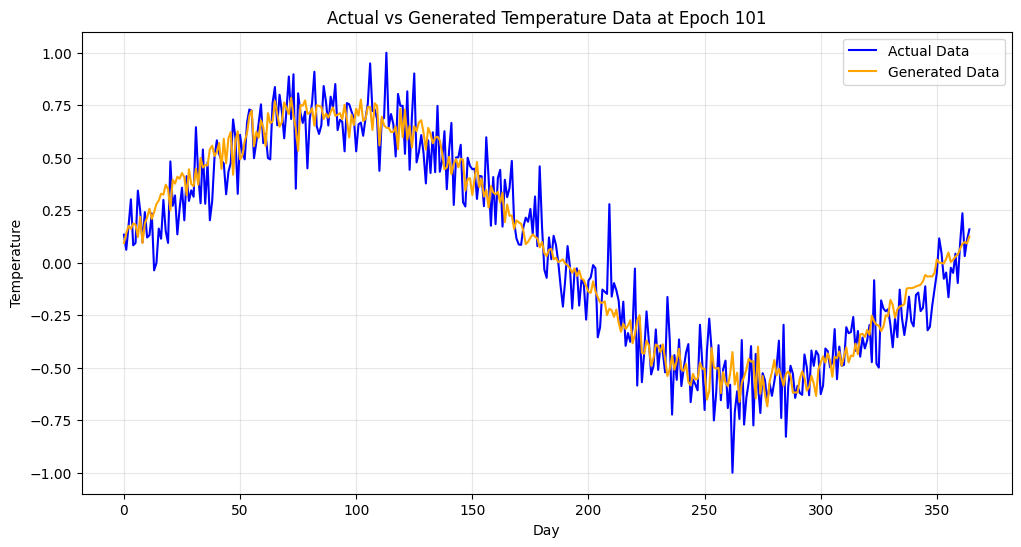

Epoch [111/1000] Loss D: 1.3855, Loss G: 0.9246, Smoothness Loss: 0.1865
Epoch [121/1000] Loss D: 1.3870, Loss G: 0.9313, Smoothness Loss: 0.1874
Epoch [131/1000] Loss D: 1.3857, Loss G: 0.9175, Smoothness Loss: 0.1866
Epoch [141/1000] Loss D: 1.3893, Loss G: 0.9325, Smoothness Loss: 0.1890
Epoch [151/1000] Loss D: 1.3890, Loss G: 0.9228, Smoothness Loss: 0.1872
Epoch [161/1000] Loss D: 1.3880, Loss G: 0.8906, Smoothness Loss: 0.1859
Epoch [171/1000] Loss D: 1.3847, Loss G: 0.9000, Smoothness Loss: 0.1851
Epoch [181/1000] Loss D: 1.3860, Loss G: 0.8978, Smoothness Loss: 0.1855
Epoch [191/1000] Loss D: 1.3850, Loss G: 0.9018, Smoothness Loss: 0.1859
Epoch [201/1000] Loss D: 1.3898, Loss G: 0.8825, Smoothness Loss: 0.1855


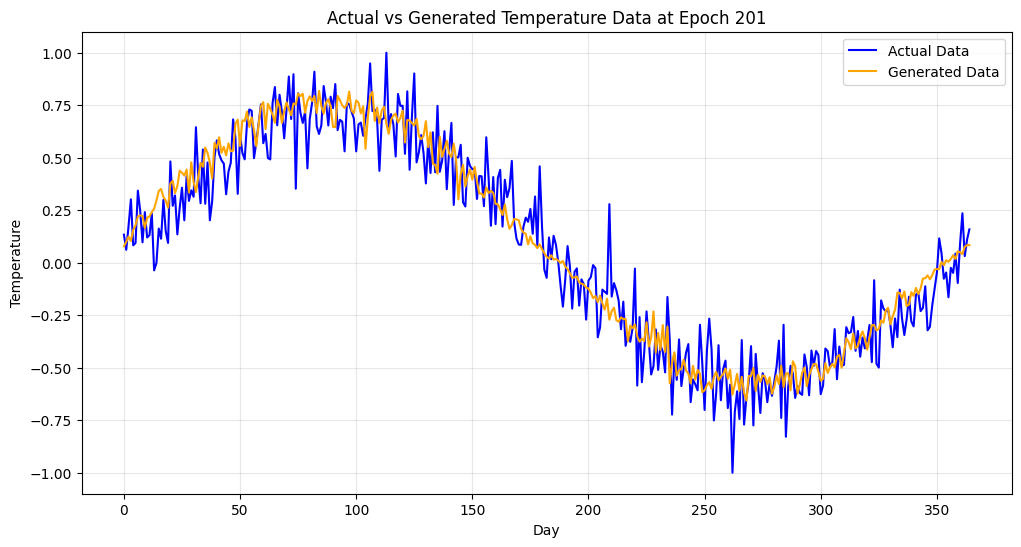

Epoch [211/1000] Loss D: 1.3837, Loss G: 0.8992, Smoothness Loss: 0.1858
Epoch [221/1000] Loss D: 1.3843, Loss G: 0.8797, Smoothness Loss: 0.1858
Epoch [231/1000] Loss D: 1.3858, Loss G: 0.8917, Smoothness Loss: 0.1860
Epoch [241/1000] Loss D: 1.3877, Loss G: 0.9005, Smoothness Loss: 0.1847
Epoch [251/1000] Loss D: 1.3883, Loss G: 0.9028, Smoothness Loss: 0.1858
Epoch [261/1000] Loss D: 1.3866, Loss G: 0.8837, Smoothness Loss: 0.1852
Epoch [271/1000] Loss D: 1.3885, Loss G: 0.8917, Smoothness Loss: 0.1848
Epoch [281/1000] Loss D: 1.3860, Loss G: 0.8874, Smoothness Loss: 0.1853
Epoch [291/1000] Loss D: 1.3845, Loss G: 0.8925, Smoothness Loss: 0.1855
Epoch [301/1000] Loss D: 1.3866, Loss G: 0.8947, Smoothness Loss: 0.1860


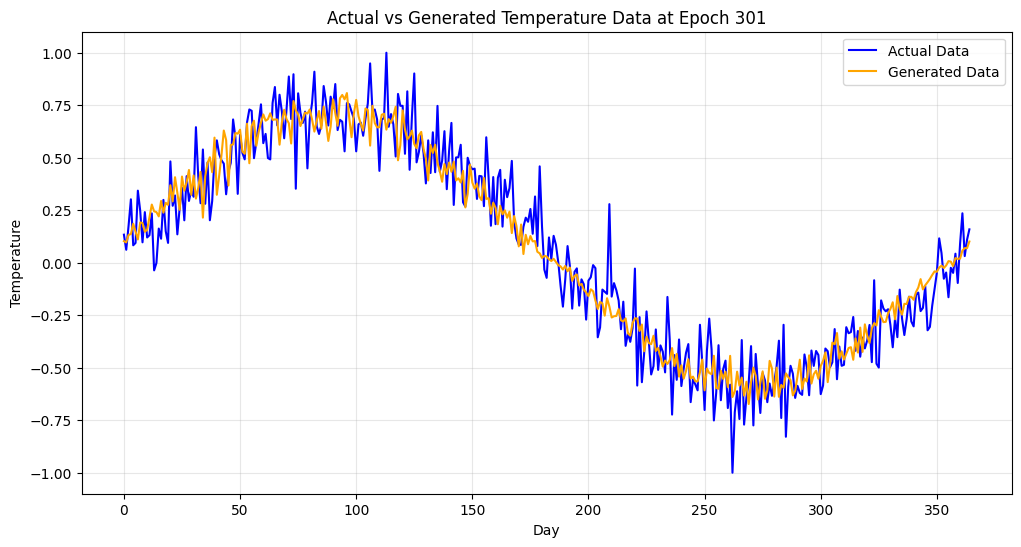

Epoch [311/1000] Loss D: 1.3911, Loss G: 0.9035, Smoothness Loss: 0.1855
Epoch [321/1000] Loss D: 1.3869, Loss G: 0.8892, Smoothness Loss: 0.1853
Epoch [331/1000] Loss D: 1.3841, Loss G: 0.8894, Smoothness Loss: 0.1848
Epoch [341/1000] Loss D: 1.3873, Loss G: 0.8752, Smoothness Loss: 0.1857
Epoch [351/1000] Loss D: 1.3876, Loss G: 0.8904, Smoothness Loss: 0.1853
Epoch [361/1000] Loss D: 1.3879, Loss G: 0.8799, Smoothness Loss: 0.1851
Epoch [371/1000] Loss D: 1.3884, Loss G: 0.8786, Smoothness Loss: 0.1849
Epoch [381/1000] Loss D: 1.3846, Loss G: 0.8793, Smoothness Loss: 0.1850
Epoch [391/1000] Loss D: 1.3868, Loss G: 0.8960, Smoothness Loss: 0.1850
Epoch [401/1000] Loss D: 1.3841, Loss G: 0.8892, Smoothness Loss: 0.1852


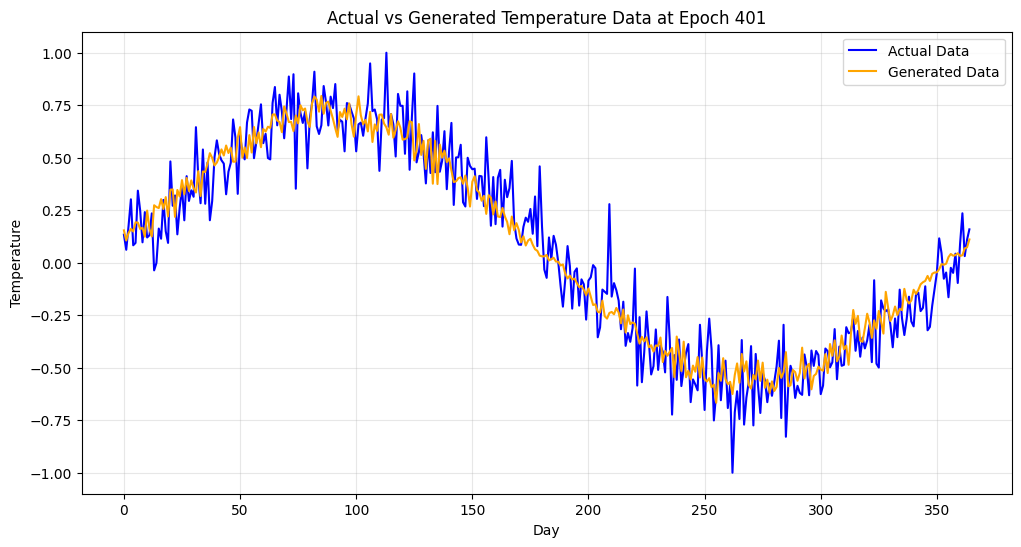

Epoch [411/1000] Loss D: 1.3849, Loss G: 0.8878, Smoothness Loss: 0.1850
Epoch [421/1000] Loss D: 1.3856, Loss G: 0.8952, Smoothness Loss: 0.1855
Epoch [431/1000] Loss D: 1.3885, Loss G: 0.8889, Smoothness Loss: 0.1844
Epoch [441/1000] Loss D: 1.3873, Loss G: 0.8856, Smoothness Loss: 0.1854
Epoch [451/1000] Loss D: 1.3877, Loss G: 0.8820, Smoothness Loss: 0.1849
Epoch [461/1000] Loss D: 1.3865, Loss G: 0.8870, Smoothness Loss: 0.1852
Epoch [471/1000] Loss D: 1.3863, Loss G: 0.8816, Smoothness Loss: 0.1855
Epoch [481/1000] Loss D: 1.3851, Loss G: 0.8713, Smoothness Loss: 0.1857
Epoch [491/1000] Loss D: 1.3874, Loss G: 0.8822, Smoothness Loss: 0.1849
Epoch [501/1000] Loss D: 1.3893, Loss G: 0.8755, Smoothness Loss: 0.1848


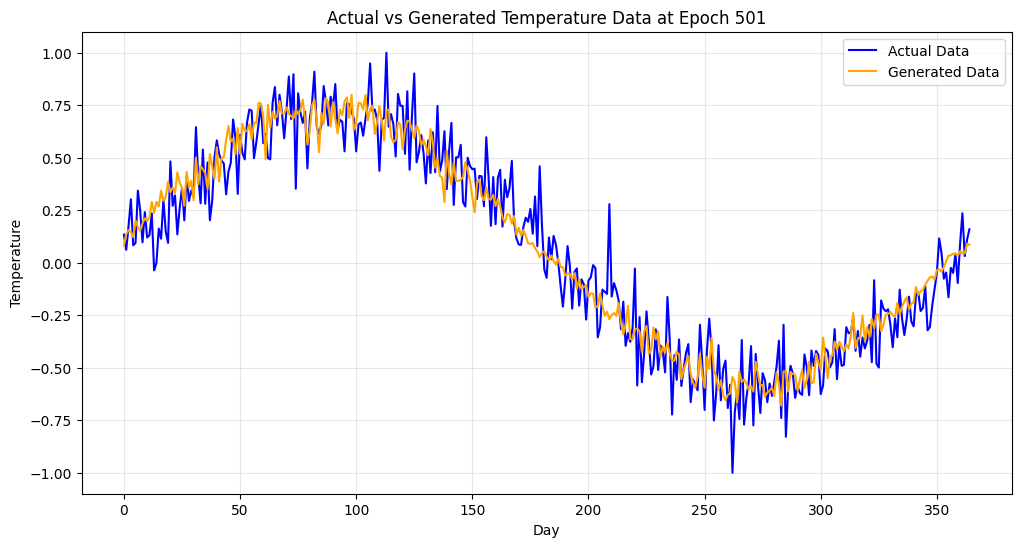

Epoch [511/1000] Loss D: 1.3872, Loss G: 0.8847, Smoothness Loss: 0.1849
Epoch [521/1000] Loss D: 1.3879, Loss G: 0.8785, Smoothness Loss: 0.1852
Epoch [531/1000] Loss D: 1.3853, Loss G: 0.8851, Smoothness Loss: 0.1850
Epoch [541/1000] Loss D: 1.3860, Loss G: 0.8904, Smoothness Loss: 0.1848
Epoch [551/1000] Loss D: 1.3880, Loss G: 0.8775, Smoothness Loss: 0.1848
Epoch [561/1000] Loss D: 1.3859, Loss G: 0.8879, Smoothness Loss: 0.1851
Epoch [571/1000] Loss D: 1.3887, Loss G: 0.8916, Smoothness Loss: 0.1852
Epoch [581/1000] Loss D: 1.3856, Loss G: 0.8937, Smoothness Loss: 0.1858
Epoch [591/1000] Loss D: 1.3875, Loss G: 0.8816, Smoothness Loss: 0.1852
Epoch [601/1000] Loss D: 1.3880, Loss G: 0.8875, Smoothness Loss: 0.1847


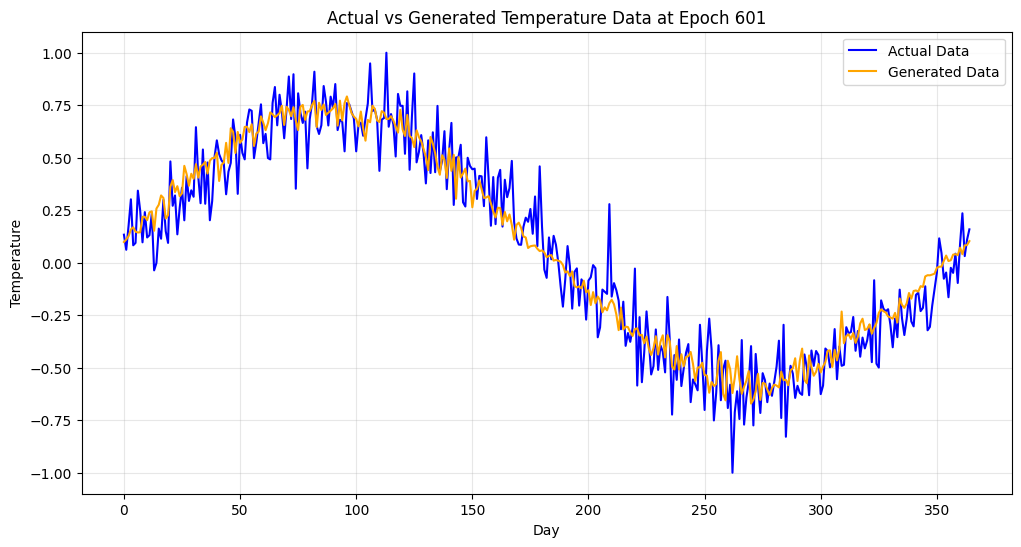

Epoch [611/1000] Loss D: 1.3841, Loss G: 0.8741, Smoothness Loss: 0.1849
Epoch [621/1000] Loss D: 1.3857, Loss G: 0.8797, Smoothness Loss: 0.1854
Epoch [631/1000] Loss D: 1.3870, Loss G: 0.8745, Smoothness Loss: 0.1855
Epoch [641/1000] Loss D: 1.3824, Loss G: 0.8838, Smoothness Loss: 0.1857
Epoch [651/1000] Loss D: 1.3880, Loss G: 0.8895, Smoothness Loss: 0.1854
Epoch [661/1000] Loss D: 1.3878, Loss G: 0.8813, Smoothness Loss: 0.1849
Epoch [671/1000] Loss D: 1.3854, Loss G: 0.8790, Smoothness Loss: 0.1853
Epoch [681/1000] Loss D: 1.3891, Loss G: 0.8866, Smoothness Loss: 0.1856
Epoch [691/1000] Loss D: 1.3868, Loss G: 0.8925, Smoothness Loss: 0.1855
Epoch [701/1000] Loss D: 1.3853, Loss G: 0.8844, Smoothness Loss: 0.1860


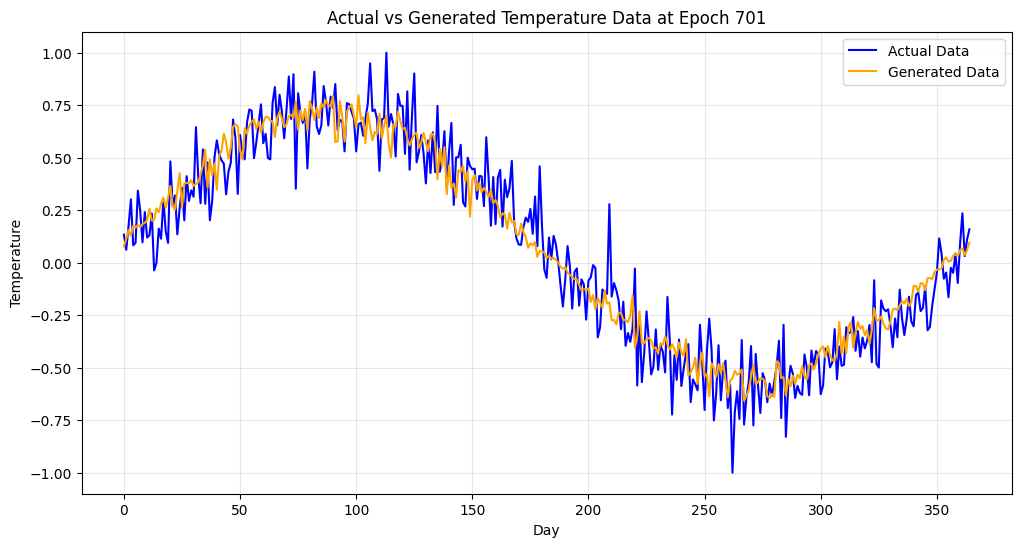

Epoch [711/1000] Loss D: 1.3886, Loss G: 0.8814, Smoothness Loss: 0.1855
Epoch [721/1000] Loss D: 1.3872, Loss G: 0.8886, Smoothness Loss: 0.1855
Epoch [731/1000] Loss D: 1.3840, Loss G: 0.8945, Smoothness Loss: 0.1848
Epoch [741/1000] Loss D: 1.3867, Loss G: 0.8938, Smoothness Loss: 0.1853
Epoch [751/1000] Loss D: 1.3869, Loss G: 0.8827, Smoothness Loss: 0.1854
Epoch [761/1000] Loss D: 1.3894, Loss G: 0.9007, Smoothness Loss: 0.1856
Epoch [771/1000] Loss D: 1.3862, Loss G: 0.8961, Smoothness Loss: 0.1855
Epoch [781/1000] Loss D: 1.3892, Loss G: 0.8846, Smoothness Loss: 0.1854
Epoch [791/1000] Loss D: 1.3858, Loss G: 0.8861, Smoothness Loss: 0.1857
Epoch [801/1000] Loss D: 1.3876, Loss G: 0.8916, Smoothness Loss: 0.1849


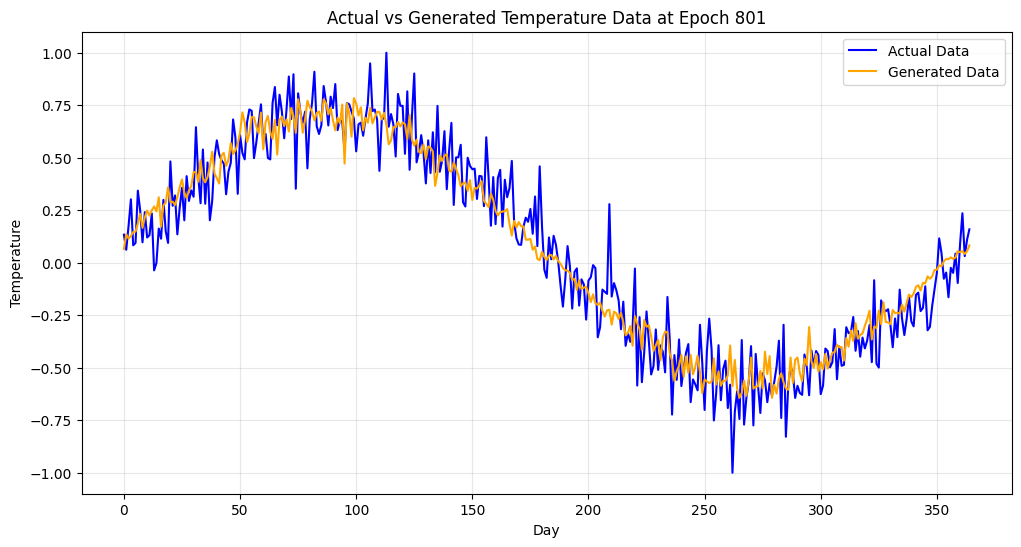

Epoch [811/1000] Loss D: 1.3883, Loss G: 0.8916, Smoothness Loss: 0.1852
Epoch [821/1000] Loss D: 1.3885, Loss G: 0.8910, Smoothness Loss: 0.1855
Epoch [831/1000] Loss D: 1.3857, Loss G: 0.8903, Smoothness Loss: 0.1859
Epoch [841/1000] Loss D: 1.3874, Loss G: 0.8909, Smoothness Loss: 0.1846
Epoch [851/1000] Loss D: 1.3890, Loss G: 0.8947, Smoothness Loss: 0.1845
Epoch [861/1000] Loss D: 1.3868, Loss G: 0.8864, Smoothness Loss: 0.1850
Epoch [871/1000] Loss D: 1.3887, Loss G: 0.8875, Smoothness Loss: 0.1855
Epoch [881/1000] Loss D: 1.3863, Loss G: 0.8723, Smoothness Loss: 0.1854
Epoch [891/1000] Loss D: 1.3838, Loss G: 0.8991, Smoothness Loss: 0.1854
Epoch [901/1000] Loss D: 1.3844, Loss G: 0.8858, Smoothness Loss: 0.1857


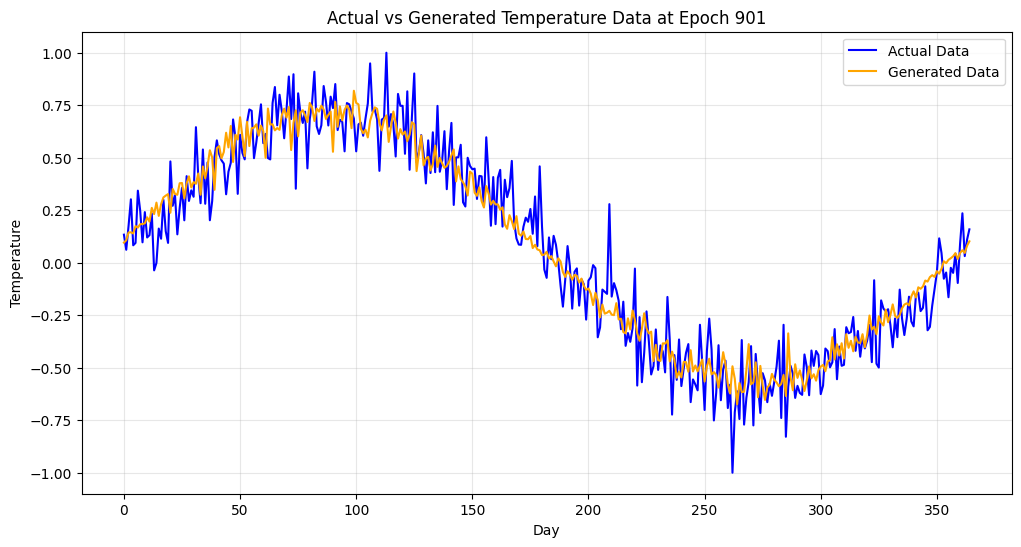

Epoch [911/1000] Loss D: 1.3845, Loss G: 0.8876, Smoothness Loss: 0.1853
Epoch [921/1000] Loss D: 1.3861, Loss G: 0.8765, Smoothness Loss: 0.1850
Epoch [931/1000] Loss D: 1.3884, Loss G: 0.8968, Smoothness Loss: 0.1853
Epoch [941/1000] Loss D: 1.3867, Loss G: 0.8908, Smoothness Loss: 0.1859
Epoch [951/1000] Loss D: 1.3865, Loss G: 0.8880, Smoothness Loss: 0.1852
Epoch [961/1000] Loss D: 1.3874, Loss G: 0.8881, Smoothness Loss: 0.1849
Epoch [971/1000] Loss D: 1.3871, Loss G: 0.8916, Smoothness Loss: 0.1855
Epoch [981/1000] Loss D: 1.3888, Loss G: 0.8793, Smoothness Loss: 0.1850
Epoch [991/1000] Loss D: 1.3823, Loss G: 0.8936, Smoothness Loss: 0.1851


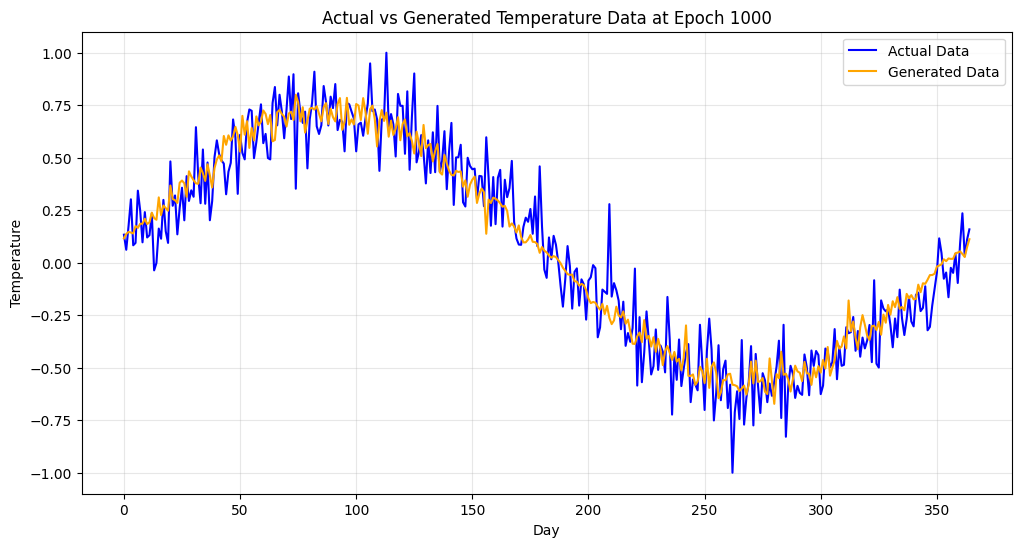

In [20]:
# Training Loop with improved stability techniques
for epoch in range(num_epochs):
    g_loss_epoch = 0
    d_loss_epoch = 0
    smoothness_loss_epoch = 0
    
    for real_batch, real_next in dataloader:
        batch_size = real_batch.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        # Train discriminator
        for _ in range(1):  # Train discriminator more than generator for stability
            OptimizerD.zero_grad()
            
            # Create sequence with real next value for discriminator
            real_sequence = torch.cat([real_batch[:, 1:, 0:1], real_next.unsqueeze(1).unsqueeze(2)], dim=1)
            real_output = discriminator(real_sequence)
            d_loss_real = adversarial_criterion(real_output, real_labels)
            
            # Generate fake data
            noise = torch.randn(batch_size, seq_length, input_dim)
            # Inject day of year information into the noise
            noise[:, :, 1] = real_batch[:, :, 1]  # Copy day of year features from real data
            
            fake_next = generator(noise)
            fake_sequence = torch.cat([real_batch[:, 1:, 0:1], fake_next], dim=1)
            
            fake_output = discriminator(fake_sequence.detach())
            d_loss_fake = adversarial_criterion(fake_output, fake_labels)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)  # Gradient clipping
            OptimizerD.step()
        
        # Train generator
        OptimizerG.zero_grad()
        
        # Generate fake data
        noise = torch.randn(batch_size, seq_length, input_dim)
        noise[:, :, 1] = real_batch[:, :, 1]  # Copy day of year features
        
        fake_next = generator(noise)
        fake_sequence = torch.cat([real_batch[:, 1:, 0:1], fake_next], dim=1)
        
        # Adversarial loss
        fake_output = discriminator(fake_sequence)
        g_loss_adv = adversarial_criterion(fake_output, real_labels)
        
        # Content loss (match real data patterns)
        g_loss_content = mse_criterion(fake_next, real_next.unsqueeze(1).unsqueeze(2))
        
        # Smoothness loss
        smooth_loss = enhanced_smoothness_loss(fake_sequence, alpha=0.5)
        
        # Combine losses with appropriate weights
        g_loss = g_loss_adv + 10.0 * g_loss_content + 0.1 * smooth_loss
        
        g_loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)  # Gradient clipping
        OptimizerG.step()
        
        # Update loss tracking
        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()
        smoothness_loss_epoch += smooth_loss.item()
    
    # Calculate average losses for this epoch
    avg_g_loss = g_loss_epoch / len(dataloader)
    avg_d_loss = d_loss_epoch / len(dataloader)
    avg_smooth_loss = smoothness_loss_epoch / len(dataloader)
    
    # Update learning rate schedulers
    scheduler_G.step(avg_g_loss)
    scheduler_D.step(avg_d_loss)
    
    # Store loss history
    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)
    smooth_losses.append(avg_smooth_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {avg_d_loss:.4f}, "
              f"Loss G: {avg_g_loss:.4f}, Smoothness Loss: {avg_smooth_loss:.4f}")
    
    # Monitor generated data periodically
    if epoch % 100 == 0 or epoch == num_epochs - 1:
        # Generate a sample sequence for visualization
        test_size = 365
        with torch.no_grad():
            # Create input sequence
            test_noise = torch.randn(1, seq_length, input_dim)  # Start with batch size 1
            
            # Add seasonal pattern for day of year
            days_for_test = np.arange(test_size + seq_length)
            day_of_year_test = np.sin(2 * np.pi * days_for_test / 365.25)
            
            # Set the day of year for the initial sequence
            for i in range(seq_length):
                test_noise[0, i, 1] = torch.tensor(day_of_year_test[i], dtype=torch.float32)
            
            # Generate temperature values autoregressively
            generated_values = []
            current_seq = test_noise  # Shape: [1, seq_length, input_dim]
            
            for i in range(test_size):
                # Generate next value
                next_val = generator(current_seq).squeeze().item()
                generated_values.append(next_val)
                
                # Update sequence for next prediction (slide window)
                if i < test_size - 1:
                    # Get the values except the first timestep
                    shifted_seq = current_seq[:, 1:, :].clone()  # Shape: [1, seq_length-1, input_dim]
                    
                    # Create the new timestep tensor with the right dimensions
                    new_timestep = torch.zeros(1, 1, input_dim)
                    new_timestep[0, 0, 0] = next_val
                    new_timestep[0, 0, 1] = day_of_year_test[i + seq_length]
                    
                    # Concatenate along the sequence dimension (dim=1)
                    current_seq = torch.cat([shifted_seq, new_timestep], dim=1)
        
        # Convert normalized values back to original scale
        generated_values_denorm = scaler.inverse_transform(
            np.array(generated_values).reshape(-1, 1)).flatten()
        
        # Get a sample of actual data for comparison (same length as generated data)
        if len(temperature_data) >= test_size:
            actual_sample = temperature_data[:test_size]
            
            # Plot generated data and actual data
            plt.figure(figsize=(12, 6))
            plt.plot(actual_sample, label='Actual Data', color='blue')
            plt.plot(generated_values_denorm, label='Generated Data', color='orange')
            plt.title(f'Actual vs Generated Temperature Data at Epoch {epoch+1}')
            plt.xlabel('Day')
            plt.ylabel('Temperature')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        else:
            # Plot only generated data if actual data is insufficient
            plt.figure(figsize=(12, 6))
            plt.plot(generated_values_denorm, label='Generated Data', color='orange')
            plt.title(f'Generated Temperature Data at Epoch {epoch+1}')
            plt.xlabel('Day')
            plt.ylabel('Temperature')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()


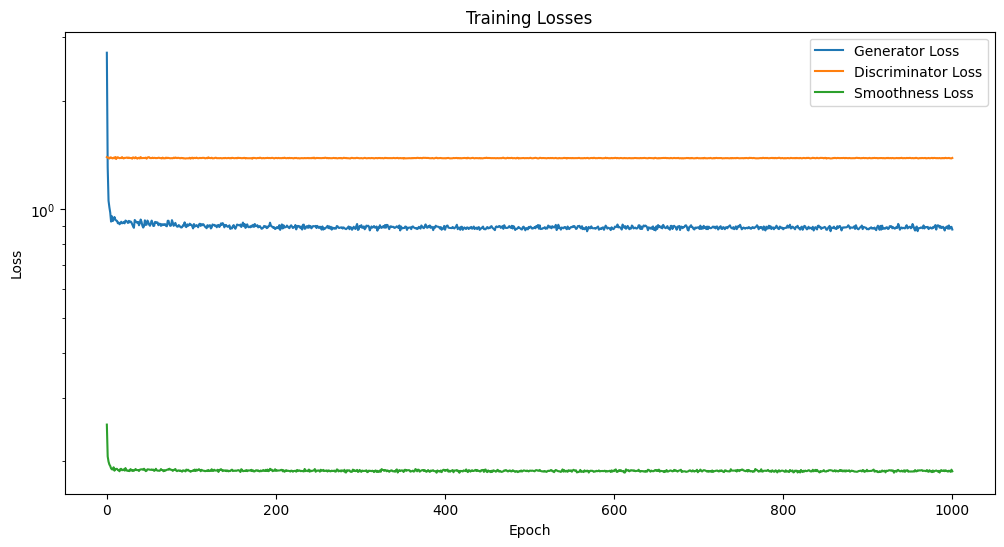

In [30]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(smooth_losses, label='Smoothness Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.show()

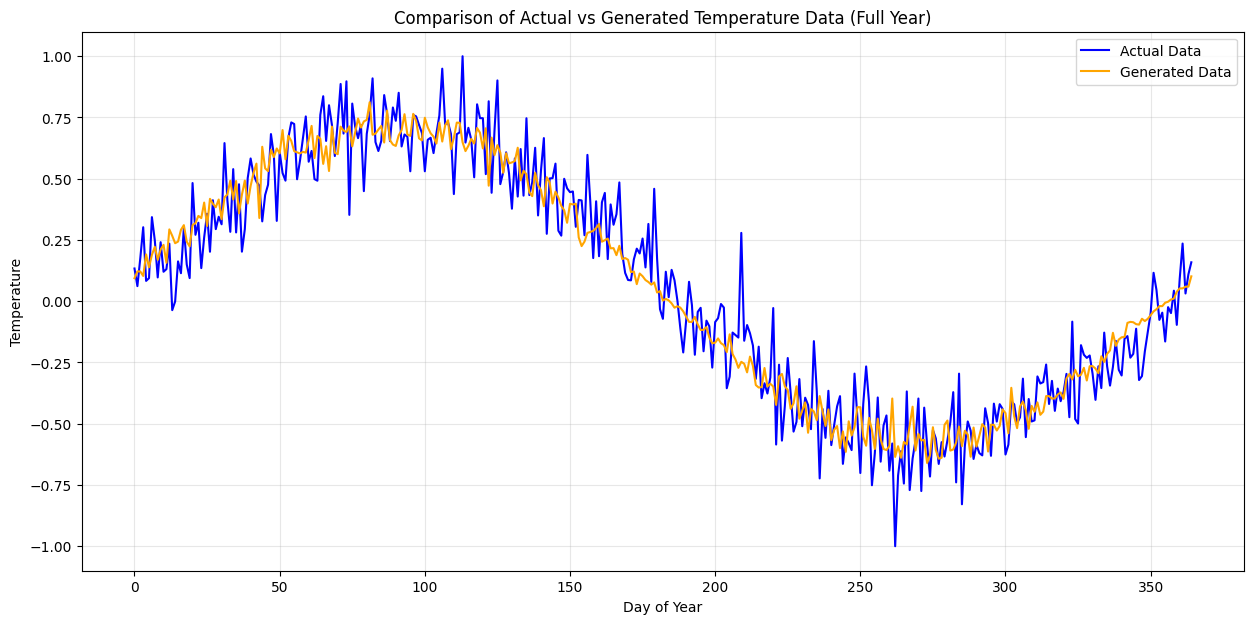

Mean Squared Error: 0.0189
Mean Absolute Error: 0.1097
Correlation Coefficient: 0.9570


In [33]:
# Final evaluation - generate a full year of data autoregressively
days_in_year = 365
with torch.no_grad():
    # Create initial sequence - make sure it's properly normalized
    # Use some actual data to start with instead of random noise
    if len(temperature_data) >= seq_length:
        # Start with actual data (properly normalized)
        initial_data = temperature_data[:seq_length]
        # Convert to normalized form if your model expects normalized inputs
        initial_data_norm = scaler.transform(initial_data.reshape(-1, 1)).flatten()
        
        # Create proper input sequence
        test_input = torch.zeros(1, seq_length, input_dim)
        # Set temperature values
        for i in range(seq_length):
            test_input[0, i, 0] = torch.tensor(initial_data_norm[i], dtype=torch.float32)
    else:
        # If no actual data, use normalized random values in the expected range
        test_input = torch.zeros(1, seq_length, input_dim)
        # Use reasonable values instead of random noise
        temp_norm = torch.tensor(np.random.uniform(-1, 1, seq_length), dtype=torch.float32)
        for i in range(seq_length):
            test_input[0, i, 0] = temp_norm[i]
    
    # Add seasonal pattern for day of year
    days_for_test = np.arange(days_in_year + seq_length)
    day_of_year_test = np.sin(2 * np.pi * days_for_test / 365.25)
    
    # Set the day of year for the initial sequence
    for i in range(seq_length):
        test_input[0, i, 1] = torch.tensor(day_of_year_test[i], dtype=torch.float32)
    
    # Generate temperature values autoregressively
    generated_year = []
    current_seq = test_input  # Shape: [1, seq_length, input_dim]
    
    for i in range(days_in_year):
        # Generate next value
        next_val = generator(current_seq).squeeze().item()
        generated_year.append(next_val)
        
        # Update sequence for next prediction
        if i < days_in_year - 1:
            # Get the sequence without the first timestep
            shifted_seq = current_seq[:, 1:, :].clone()
            
            # Create new timestep tensor with correct dimensions
            next_day_idx = seq_length + i
            new_timestep = torch.zeros(1, 1, input_dim)
            new_timestep[0, 0, 0] = next_val  # The predicted value
            new_timestep[0, 0, 1] = torch.tensor(day_of_year_test[next_day_idx], dtype=torch.float32)
            
            # Concatenate along the sequence dimension (dim=1)
            current_seq = torch.cat([shifted_seq, new_timestep], dim=1)

# Convert normalized values back to original scale
generated_year_denorm = scaler.inverse_transform(
    np.array(generated_year).reshape(-1, 1)).flatten()

# Compare with actual data if available
if len(temperature_data) >= days_in_year:
    actual_year = temperature_data[:days_in_year]
    
    plt.figure(figsize=(15, 7))
    plt.plot(actual_year, label='Actual Data', color='blue')
    plt.plot(generated_year_denorm, label='Generated Data', color='orange')
    plt.title('Comparison of Actual vs Generated Temperature Data (Full Year)')
    plt.xlabel('Day of Year')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate metrics
    mse = mean_squared_error(actual_year, generated_year_denorm)
    mae = mean_absolute_error(actual_year, generated_year_denorm)
    correlation = np.corrcoef(actual_year, generated_year_denorm)[0, 1]
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Correlation Coefficient: {correlation:.4f}")
else:
    plt.figure(figsize=(15, 7))
    plt.plot(generated_year_denorm, label='Generated Data', color='orange')
    plt.title('Generated Temperature Data (Full Year)')
    plt.xlabel('Day of Year')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()